In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Specify the file path
file_path = '/content/Kickstrater Dataset with additional features.xlsx'

# Load the dataset
df = pd.read_excel(file_path)

# Remove the specified columns
columns_to_remove = ['id', 'country', 'currency', 'name']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Convert date columns to datetime type
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['launched'] = pd.to_datetime(df['launched'], errors='coerce')

# Feature Engineering: Create a new feature for the duration between launched and deadline
df['duration'] = (df['deadline'] - df['launched']).dt.days

# Drop original date columns as they are not needed anymore
df = df.drop(columns=['deadline', 'launched'], errors='ignore')

# Convert all columns to numeric where possible, to handle mixed data types
df = df.apply(pd.to_numeric, errors='ignore')

# Perform one-hot encoding on categorical columns
df = pd.get_dummies(df, drop_first=True)

# Balance the dataset based on the y_variable
df_0 = df[df['y_variable'] == 0]
df_1 = df[df['y_variable'] == 1]

min_count = min(len(df_0), len(df_1))

df_0_balanced = df_0.sample(n=min_count, random_state=42)
df_1_balanced = df_1.sample(n=min_count, random_state=42)

df_balanced = pd.concat([df_0_balanced, df_1_balanced])

# Split the data into training and testing sets with the same proportion of classes
X = df_balanced.drop('y_variable', axis=1)
y = df_balanced['y_variable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using RFE with Logistic Regression
log_reg = LogisticRegression(random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=10)
X_train_scaled = rfe.fit_transform(X_train_scaled, y_train)
X_test_scaled = rfe.transform(X_test_scaled)

# Model Selection: Hyperparameter tuning with GridSearchCV

# Logistic Regression with Hyperparameter Tuning
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='precision')
grid_log_reg.fit(X_train_scaled, y_train)

# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [2, 5, 10, 15]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='precision')
grid_rf.fit(X_train_scaled, y_train)

# Support Vector Machine with Hyperparameter Tuning
svm = SVC(random_state=42)
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='precision')
grid_svm.fit(X_train_scaled, y_train)

# XGBoost with Hyperparameter Tuning (GPU support)
xgb = XGBClassifier(random_state=42, tree_method='gpu_hist')
param_grid_xgb = {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [3, 5, 7, 9]}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='precision')
grid_xgb.fit(X_train_scaled, y_train)

# LightGBM with Hyperparameter Tuning
lgb = LGBMClassifier(random_state=42)
param_grid_lgb = {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [3, 5, 7, 9]}
grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=5, scoring='precision')
grid_lgb.fit(X_train_scaled, y_train)

# Stacking Classifier
estimators = [
    ('log_reg', grid_log_reg.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('svm', grid_svm.best_estimator_),
    ('xgb', grid_xgb.best_estimator_),
    ('lgb', grid_lgb.best_estimator_)
]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred_log_reg = grid_log_reg.predict(X_test_scaled)
y_pred_rf = grid_rf.predict(X_test_scaled)
y_pred_svm = grid_svm.predict(X_test_scaled)
y_pred_xgb = grid_xgb.predict(X_test_scaled)
y_pred_lgb = grid_lgb.predict(X_test_scaled)
y_pred_stack = stack_clf.predict(X_test_scaled)

# Evaluation Metrics for Logistic Regression
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average=None)
recall_log_reg = recall_score(y_test, y_pred_log_reg, average=None)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average=None)

print("Logistic Regression")
print(f"Best Parameters: {grid_log_reg.best_params_}")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision (class 0): {precision_log_reg[0]:.4f}")
print(f"Precision (class 1): {precision_log_reg[1]:.4f}")
print(f"Recall (class 0): {recall_log_reg[0]:.4f}")
print(f"Recall (class 1): {recall_log_reg[1]:.4f}")
print(f"F1 Score (class 0): {f1_log_reg[0]:.4f}")
print(f"F1 Score (class 1): {f1_log_reg[1]:.4f}")

# Evaluation Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average=None)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

print("\nRandom Forest")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision (class 0): {precision_rf[0]:.4f}")
print(f"Precision (class 1): {precision_rf[1]:.4f}")
print(f"Recall (class 0): {recall_rf[0]:.4f}")
print(f"Recall (class 1): {recall_rf[1]:.4f}")
print(f"F1 Score (class 0): {f1_rf[0]:.4f}")
print(f"F1 Score (class 1): {f1_rf[1]:.4f}")

# Evaluation Metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average=None)
recall_svm = recall_score(y_test, y_pred_svm, average=None)
f1_svm = f1_score(y_test, y_pred_svm, average=None)

print("\nSupport Vector Machine")
print(f"Best Parameters: {grid_svm.best_params_}")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision (class 0): {precision_svm[0]:.4f}")
print(f"Precision (class 1): {precision_svm[1]:.4f}")
print(f"Recall (class 0): {recall_svm[0]:.4f}")
print(f"Recall (class 1): {recall_svm[1]:.4f}")
#print(f"F1 Score (


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWar

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 166, number of negative: 165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 331, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501511 -> initscore=0.006042
[LightGBM] [Info] Start training from score 0.006042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 132, number of negative: 132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 264, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 166, number of negative: 165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 331, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501511 -> initscore=0.006042
[LightGBM] [Info] Start training from score 0.006042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:51:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Ensembled Model (Stacking)
Accuracy: 0.8072
Precision (class 0): 0.7600
Precision (class 1): 0.8788
Recall (class 0): 0.9048
Recall (class 1): 0.7073
F1 Score (class 0): 0.8261
F1 Score (class 1): 0.7838


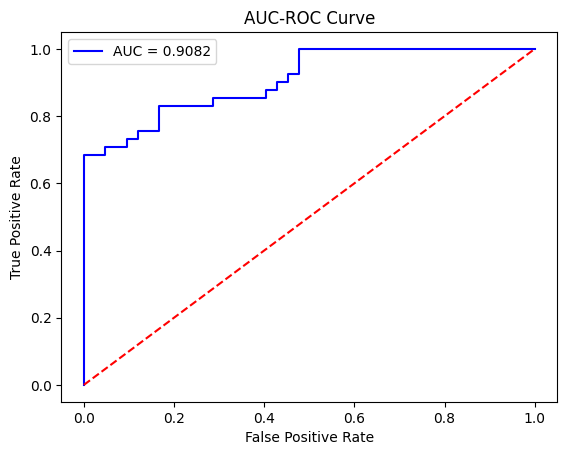

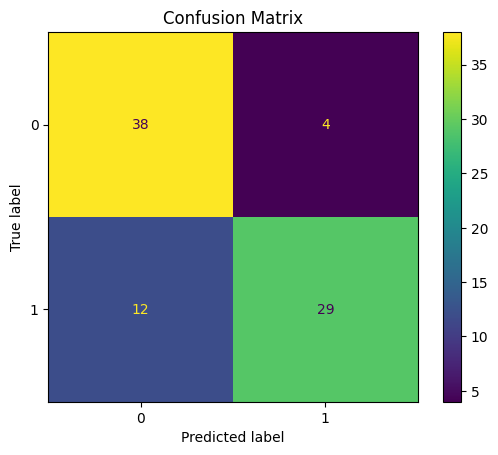

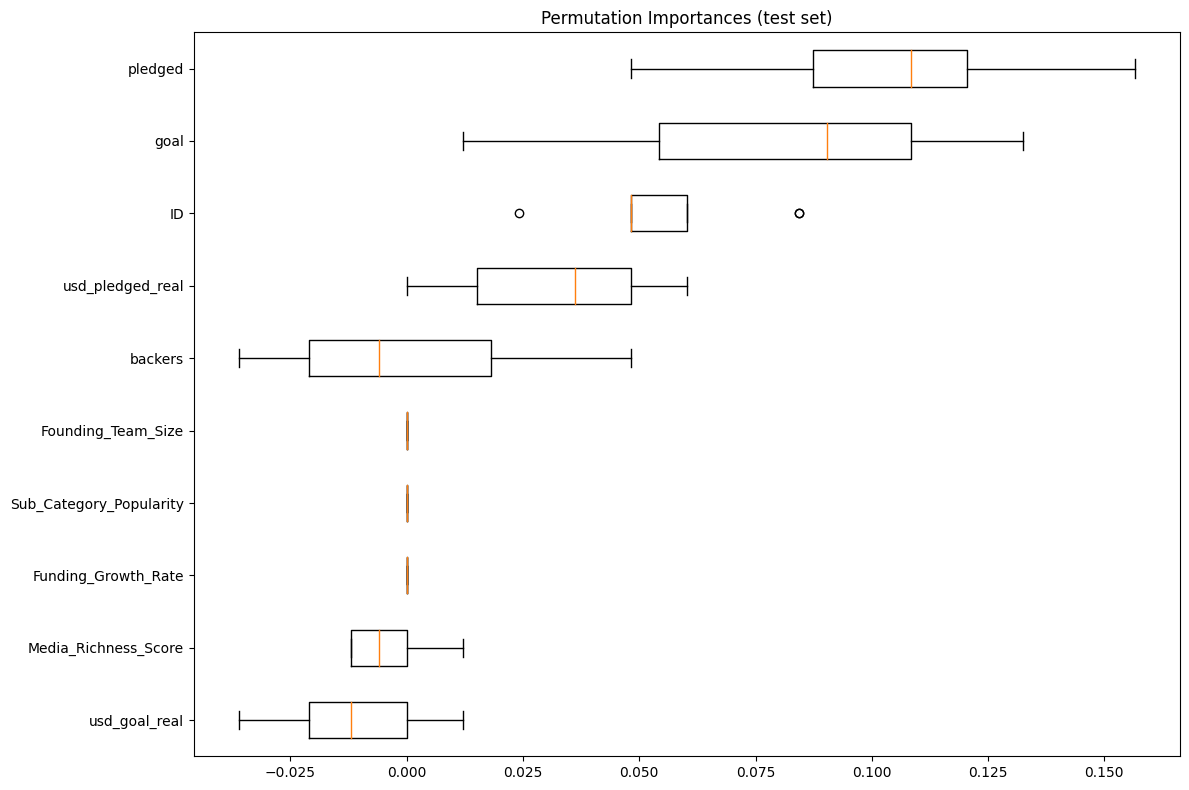

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

# Specify the file path
file_path = '/content/Kickstrater Dataset with additional features.xlsx'

# Load the dataset
df = pd.read_excel(file_path)

# Remove the specified columns
columns_to_remove = ['id', 'country', 'currency', 'name']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Convert date columns to datetime type
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['launched'] = pd.to_datetime(df['launched'], errors='coerce')

# Feature Engineering: Create a new feature for the duration between launched and deadline
df['duration'] = (df['deadline'] - df['launched']).dt.days

# Drop original date columns as they are not needed anymore
df = df.drop(columns=['deadline', 'launched'], errors='ignore')

# Convert all columns to numeric where possible, to handle mixed data types
df = df.apply(pd.to_numeric, errors='ignore')

# Perform one-hot encoding on categorical columns
df = pd.get_dummies(df, drop_first=True)

# Balance the dataset based on the y_variable
df_0 = df[df['y_variable'] == 0]
df_1 = df[df['y_variable'] == 1]

min_count = min(len(df_0), len(df_1))

df_0_balanced = df_0.sample(n=min_count, random_state=42)
df_1_balanced = df_1.sample(n=min_count, random_state=42)

df_balanced = pd.concat([df_0_balanced, df_1_balanced])

# Split the data into training and testing sets with the same proportion of classes
X = df_balanced.drop('y_variable', axis=1)
y = df_balanced['y_variable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using RFE with Logistic Regression
log_reg = LogisticRegression(random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=10)
X_train_scaled = rfe.fit_transform(X_train_scaled, y_train)
X_test_scaled = rfe.transform(X_test_scaled)

# Model Selection: Hyperparameter tuning with GridSearchCV and StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Logistic Regression with Hyperparameter Tuning
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=cv_strategy, scoring='precision', n_jobs=-1)
grid_log_reg.fit(X_train_scaled, y_train)

# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200, 300, 500], 'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10, 15]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv_strategy, scoring='precision', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

# Support Vector Machine with Hyperparameter Tuning
svm = SVC(probability=True, random_state=42)
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=cv_strategy, scoring='precision', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

# XGBoost with Hyperparameter Tuning (GPU support)
xgb = XGBClassifier(random_state=42, tree_method='gpu_hist', use_label_encoder=False)
param_grid_xgb = {'n_estimators': [100, 200, 300, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [3, 5, 7, 9]}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv_strategy, scoring='precision', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)

# LightGBM with Hyperparameter Tuning
lgb = LGBMClassifier(random_state=42)
param_grid_lgb = {'n_estimators': [100, 200, 300, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [3, 5, 7, 9]}
grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=cv_strategy, scoring='precision', n_jobs=-1)
grid_lgb.fit(X_train_scaled, y_train)

# Stacking Classifier
estimators = [
    ('log_reg', grid_log_reg.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('svm', grid_svm.best_estimator_),
    ('xgb', grid_xgb.best_estimator_),
    ('lgb', grid_lgb.best_estimator_)
]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv_strategy, n_jobs=-1)
stack_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred_stack = stack_clf.predict(X_test_scaled)
y_pred_proba_stack = stack_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics for the Ensembled Model
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack, average=None)
recall_stack = recall_score(y_test, y_pred_stack, average=None)
f1_stack = f1_score(y_test, y_pred_stack, average=None)

print("\nEnsembled Model (Stacking)")
print(f"Accuracy: {accuracy_stack:.4f}")
print(f"Precision (class 0): {precision_stack[0]:.4f}")
print(f"Precision (class 1): {precision_stack[1]:.4f}")
print(f"Recall (class 0): {recall_stack[0]:.4f}")
print(f"Recall (class 1): {recall_stack[1]:.4f}")
print(f"F1 Score (class 0): {f1_stack[0]:.4f}")
print(f"F1 Score (class 1): {f1_stack[1]:.4f}")

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_stack)
auc_score = roc_auc_score(y_test, y_pred_proba_stack)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Permutation Feature Importance for the Stacking Classifier
result = permutation_importance(stack_clf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plotting feature importances with proper labels
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics for the Ensembled Model
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack, average=None)
recall_stack = recall_score(y_test, y_pred_stack, average=None)
f1_stack = f1_score(y_test, y_pred_stack, average=None)

# Calculate overall precision, recall, and f1-score
overall_precision_stack = precision_score(y_test, y_pred_stack, average='macro')
overall_recall_stack = recall_score(y_test, y_pred_stack, average='macro')
overall_f1_stack = f1_score(y_test, y_pred_stack, average='macro')

# Calculate accuracy for each class
accuracy_class_0 = accuracy_score(y_test[y_test == 0], y_pred_stack[y_test == 0])
accuracy_class_1 = accuracy_score(y_test[y_test == 1], y_pred_stack[y_test == 1])

print("\nEnsembled Model (Stacking)")
print(f"Overall Accuracy: {accuracy_stack:.4f}")
print(f"Accuracy (class 0): {accuracy_class_0:.4f}")
print(f"Accuracy (class 1): {accuracy_class_1:.4f}")
print(f"Overall Precision: {overall_precision_stack:.4f}")
print(f"Precision (class 0): {precision_stack[0]:.4f}")
print(f"Precision (class 1): {precision_stack[1]:.4f}")
print(f"Overall Recall: {overall_recall_stack:.4f}")
print(f"Recall (class 0): {recall_stack[0]:.4f}")
print(f"Recall (class 1): {recall_stack[1]:.4f}")
print(f"Overall F1 Score: {overall_f1_stack:.4f}")
print(f"F1 Score (class 0): {f1_stack[0]:.4f}")
print(f"F1 Score (class 1): {f1_stack[1]:.4f}")


Ensembled Model (Stacking)
Overall Accuracy: 0.8072
Accuracy (class 0): 0.9048
Accuracy (class 1): 0.7073
Overall Precision: 0.8194
Precision (class 0): 0.7600
Precision (class 1): 0.8788
Overall Recall: 0.8060
Recall (class 0): 0.9048
Recall (class 1): 0.7073
Overall F1 Score: 0.8049
F1 Score (class 0): 0.8261
F1 Score (class 1): 0.7838


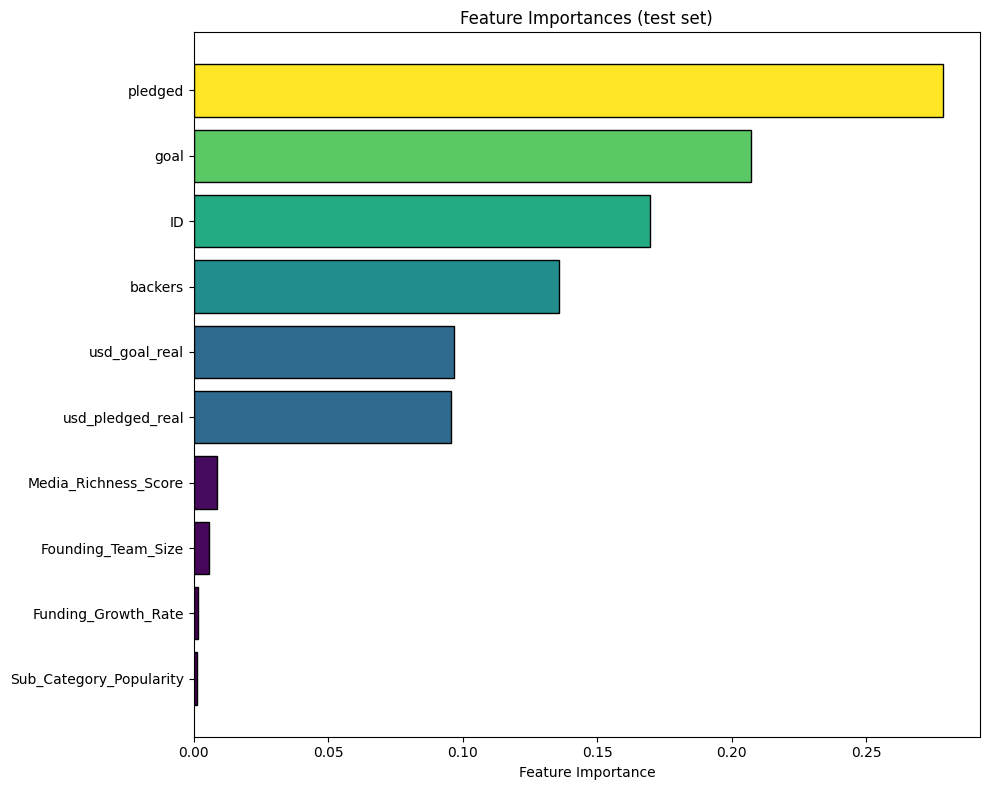

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
import seaborn as sns

# Assuming `grid_rf` is your trained Random Forest model and `X_test_scaled`, `y_test` are your test data and labels

# Compute feature importance
feature_importances = grid_rf.best_estimator_.feature_importances_

# Sorting indices
sorted_idx = np.argsort(feature_importances)

# Creating the plot
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(feature_importances.min(), feature_importances.max())

bar_colors = cmap(norm(feature_importances[sorted_idx]))

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], color=bar_colors, edgecolor='black')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importances (test set)")
plt.tight_layout()
plt.show()

